In [4]:
import numpy as np
import pandas as pd
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

In [2]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
Updating files:  18% (550/3014)
Updating files:  19% (573/3014)
Updating files:  20% (603/3014)
Updating files:  21% (633/3014)
Updating files:  22% (664/3014)
Updating files:  23% (694/3014)
Updating files:  24% (724/3014)
Updating files:  25% (754/3014)
Updating files:  26% (784/3014)
Updating files:  27% (814/3014)
Updating files:  28% (844/3014)
Updating files:  29% (875/3014)
Updating files:  30% (905/3014)
Updating files:  31% (935/3014)
Updating files:  32% (965/3014)
Updating files:  33% (995/3014)
Updating files:  34% (1025/3014)
Updating files:  35% (1055/3014)
Updating files:  36% (1086/3014)
Updating files:  36% (1087/3014)
Updating files:  37% (1116/3014)
Updating files:  38% (1146/3014)
Updating files:  39% (1176/3014)
Updating files:  40% (1206/3014)
Updating files:  41% (1236/3014)
Updating files:  42% (1266/3014)
Updating files:  43% (1297/3014)
Updating files:  44% (1327/3014)
Updating files:  45% (1357/3014)
Updating files:

In [ ]:
n_mfcc = 20   # number of MFCC we will use
freq = 16000   # sampling rate

#getting the list of files from the local repository
from pathlib import Path

path_to_audio_folder = Path("free-spoken-digit-dataset/recordings")
audiofiles = [str(file) for file in path_to_audio_folder.glob('*.wav')]

# creating a dictionary to store data
data = {'mfcc':[], 'labels':[]}

for i, file in enumerate(audiofiles):
    fileid = Path(file).name  
    label  = fileid.split('_')[0]
    data["labels"].append(label)

    audio, sr = librosa.load(file, sr=freq)
    mfcc = librosa.feature.mfcc(y=audio, sr=freq, n_fft=512, n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc, axis=1)
    data["mfcc"].append(feature_vector)


In [ ]:
# verify that we got all the 3000 audio files
print('Got {} rows of data'.format(len(data['mfcc'])))

# we create the flattened matrix of MFCCs -->  go from a list of arrays to a 2D matrix
MFCC_matrix =np.asarray( data['mfcc'])

# ...same for the labels vector
LABELS_vector = np.asarray(data["labels"])

print('Dimension of vector of labels is: {}'.format(LABELS_vector.shape))
print('Dimension of matrix of feautures is: {}'.format(MFCC_matrix.shape))

Got 3000 rows of data
Dimension of vector of labels is: (3000,)
Dimension of matrix of feautures is: (3000, 20)


In [10]:
ipd.Audio(audio, rate=sr)

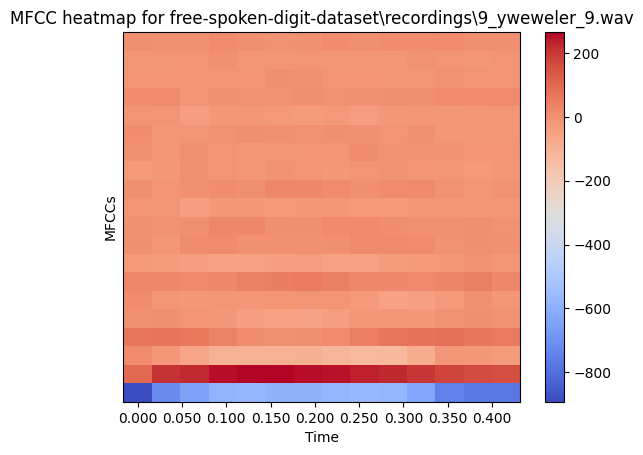

In [ ]:
# we check the MFCC heatmap for the last audio file
librosa.display.specshow(mfcc,x_axis = 'time',sr=sr)
plt.title('MFCC heatmap for {}'.format(file))
plt.xlabel('Time')
plt.ylabel('MFCCs')
plt.colorbar()
plt.show()

In [12]:
svm = SVC()                                  # initialize SVM
rf = RandomForestClassifier(n_jobs=2)        # initialize Random Forest
knn = KNeighborsClassifier()                 # initialize KNN

In [13]:
# support vector
print('The accuracy for the SVM is {}'.
      format(cross_val_score(svm, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the SVM is 0.5246666666666666


In [14]:
# random forest
print('The accuracy for the Random Forest is {}'.
      format(cross_val_score(rf, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the Random Forest is 0.909


In [15]:
# kNN
print('The accuracy for the KNN is {}'.
      format(cross_val_score(knn, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the KNN is 0.8733333333333334


In [ ]:

y = LABELS_vector
X = MFCC_matrix

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=0.2, stratify=y)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [17]:
# Check how the test sample are the same number for each digit
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'0': 240,
 '1': 240,
 '2': 240,
 '3': 240,
 '4': 240,
 '5': 240,
 '6': 240,
 '7': 240,
 '8': 240,
 '9': 240}

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2'],   # fixed here
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}


In [21]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# We have already created the base model to tune
# rf = RandomForestClassifier(n_jobs=2)

# Random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=2), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [ ]:
#  hyperparameters picked for the model
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [ ]:

predicted = rf_random.predict(X_test)

CONFUSION MATRIX _ RANDOM FOREST:


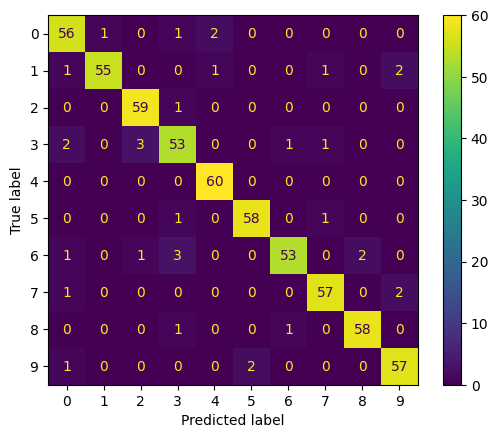

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

#confusion matrix
print('CONFUSION MATRIX _ RANDOM FOREST:')
#disp=plot_confusion_matrix(rf_random, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(rf_random, X_test, y_test)
plt.show()

In [26]:
#classification report
print('CLASSIFICATION REPORT _ RANDOM FOREST:\n\n',classification_report(y_test,predicted))
print('Accuracy:\n',accuracy_score(y_test, predicted))

CLASSIFICATION REPORT _ RANDOM FOREST:

               precision    recall  f1-score   support

           0       0.90      0.93      0.92        60
           1       0.98      0.92      0.95        60
           2       0.94      0.98      0.96        60
           3       0.88      0.88      0.88        60
           4       0.95      1.00      0.98        60
           5       0.97      0.97      0.97        60
           6       0.96      0.88      0.92        60
           7       0.95      0.95      0.95        60
           8       0.97      0.97      0.97        60
           9       0.93      0.95      0.94        60

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

Accuracy:
 0.9433333333333334


In [ ]:

print("The label for this sample in y_test is {}".format((y_test)[60]))
print("The random forest predicted for it {}".format((predicted[60])))
a = rf_random.predict_proba(X_test)
print("Each class got these probabilities: {}".format(a[60]))

The label for this sample in y_test is 8
The random forest predicted for it 8
Each class got these probabilities: [0.01666667 0.00416667 0.0025     0.09166667 0.00333333 0.01666667
 0.08916667 0.00083333 0.76833333 0.00666667]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for GridSearch
param_grid = {
    'n_estimators': [200, 500, 1000, 1500],  # Number of trees
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': [10, 20, 30, 50, None],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at each leaf node
    'bootstrap': [True, False]                # Method for sampling data
}


rf = RandomForestClassifier(n_jobs=2)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score: {:.4f}".format(grid_search.best_score_))


best_rf_model = grid_search.best_estimator_
predicted = best_rf_model.predict(X_test)


from sklearn.metrics import classification_report, accuracy_score
print('CLASSIFICATION REPORT _ RANDOM FOREST (with GridSearchCV):\n\n', classification_report(y_test, predicted))
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, predicted)))


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


In [ ]:

label_to_digit = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}


print("Class Label to Spoken Digit Mapping:")
for label, digit in label_to_digit.items():
    print(f"Class {label} --> Spoken Digit: '{digit}'")


Class Label to Spoken Digit Mapping:
Class 0 --> Spoken Digit: 'zero'
Class 1 --> Spoken Digit: 'one'
Class 2 --> Spoken Digit: 'two'
Class 3 --> Spoken Digit: 'three'
Class 4 --> Spoken Digit: 'four'
Class 5 --> Spoken Digit: 'five'
Class 6 --> Spoken Digit: 'six'
Class 7 --> Spoken Digit: 'seven'
Class 8 --> Spoken Digit: 'eight'
Class 9 --> Spoken Digit: 'nine'


In [ ]:
# Mapping of class labels to digits
label_to_digit = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}


def show_prediction_details(predicted_label):
    if predicted_label in label_to_digit:
        print(f"Predicted Class Label: {predicted_label}")
        print(f"Corresponding Spoken Digit: '{label_to_digit[predicted_label]}'")
    else:
        print("Invalid class label!")

# Example 
predicted_label = 3  
show_prediction_details(predicted_label)


Predicted Class Label: 3
Corresponding Spoken Digit: 'three'


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']   # corrected here

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}


rf = RandomForestClassifier(n_jobs=-1)

# Random search of parameters, using 3-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=1,
    n_jobs=-1
)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Now predicting
predicted = rf_random.predict(X_test)

# Printing the requested outputs
print("The label for this sample in y_test is {}".format(y_test[60]))
print("The random forest predicted for it {}".format(predicted[60]))

# Get prediction probabilities
proba = rf_random.predict_proba(X_test)
print("Each class got these probabilities: {}".format(proba[60]))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
The label for this sample in y_test is 8
The random forest predicted for it 8
Each class got these probabilities: [0.025      0.00333333 0.00416667 0.105      0.00416667 0.01
 0.09583333 0.00416667 0.74083333 0.0075    ]
